In [84]:
#Install below 2 packages (if didn't install before) before run the code
#!pip install imblearn
#!pip install -U scikit-learn

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score
import imblearn.under_sampling as samp
from sklearn.model_selection import GridSearchCV
import seaborn as sb
from sklearn import metrics
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score, confusion_matrix,mean_squared_error,classification_report
import math,warnings
import joblib
warnings.filterwarnings('ignore')

In [86]:
df = pd.read_csv("mail_data.csv")
df.shape

(5572, 2)

In [87]:
print(df.isnull().sum())
print("")
print(df.describe())

Category    0
Message     0
dtype: int64

       Category                 Message
count      5572                    5572
unique        2                    5157
top         ham  Sorry, I'll call later
freq       4825                      30


In [88]:
df.head()

Category                                            Message
0      ham  Go until jurong point, crazy.. Available only ...
1      ham                      Ok lar... Joking wif u oni...
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...
3      ham  U dun say so early hor... U c already then say...
4      ham  Nah I don't think he goes to usf, he lives aro...

In [89]:
#spam = 1, ham = 0
df["Target"] = np.where(df["Category"] == "spam",1,0)
df.head()

Category                                            Message  Target
0      ham  Go until jurong point, crazy.. Available only ...       0
1      ham                      Ok lar... Joking wif u oni...       0
2     spam  Free entry in 2 a wkly comp to win FA Cup fina...       1
3      ham  U dun say so early hor... U c already then say...       0
4      ham  Nah I don't think he goes to usf, he lives aro...       0

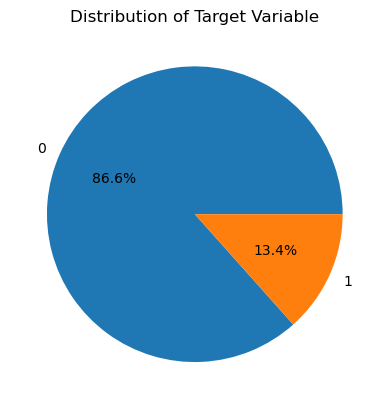

In [90]:
plt.pie(df['Target'].value_counts().values, labels=[0, 1], autopct='%1.1f%%')
plt.title("Distribution of Target Variable")
plt.show()

In [91]:
pd.Series(df.Target).value_counts()

0    4825
1     747
Name: Target, dtype: int64

In [92]:
x = df["Message"]
y = df["Target"]

In [93]:
#Feature Extraction (Vertorize is convert the features from string to integer because model cannot understand string)
feature_extraction = TfidfVectorizer(min_df=1,stop_words="english",lowercase=True)
x_feature = feature_extraction.fit_transform(x)

In [94]:
#Remove some data that is 0 (ham) and make the data distribution from 86.6%: 13.4% to 60.0%: 40.0%
under_samp = samp.ClusterCentroids(sampling_strategy={1:747, 0:1121},random_state=1, voting='hard')
x_samp,y_samp = under_samp.fit_resample(x_feature,y)

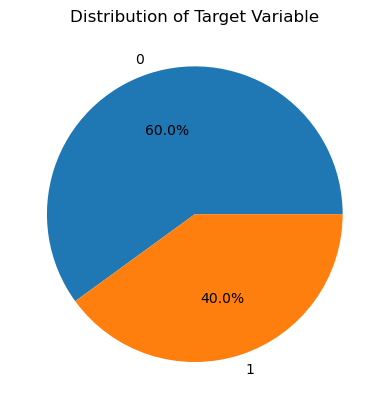

In [95]:
plt.pie(y_samp.value_counts().values, labels=[0, 1], autopct='%1.1f%%')
plt.title("Distribution of Target Variable")
plt.show()

In [96]:
xtrain,xtest,ytrain,ytest = train_test_split(x_samp,y_samp,test_size=0.2,random_state=5)
#distribute dataset into train and test

### Logistic Regression

In [97]:
from sklearn.linear_model import LogisticRegression

In [98]:
lr = LogisticRegression()
parameters_lr = [{'C': list(np.arange(1000, 2000, 200)),
 'fit_intercept': [True, False],
 'tol' : [1e-5,1e-4],
 'solver' : ['newton-cg','lbfgs']}]
lr_grid = GridSearchCV(lr, parameters_lr)
lr_grid.fit(xtrain,ytrain)
print(lr_grid.best_params_)

{'C': 1000, 'fit_intercept': True, 'solver': 'newton-cg', 'tol': 1e-05}


In [99]:
lr_best = LogisticRegression(C = 1000, fit_intercept = True, solver= 'newton-cg', tol= 1e-05)
lr_best.fit(xtrain,ytrain)
lr_pred =  lr_best.predict(xtest)
lr_acc = (lr_best.score(xtest,ytest)) * 100
print('Logistic Regression accuracy : {:.2f}%'.format(lr_acc))

Logistic Regression accuracy : 94.12%


In [100]:
print(classification_report(ytest,lr_pred))
lr_pre = precision_score(ytest, lr_pred) * 100
lr_rec = recall_score(ytest, lr_pred)* 100
lr_f1 = f1_score(ytest, lr_pred)* 100

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       227
           1       0.98      0.86      0.92       147

    accuracy                           0.94       374
   macro avg       0.95      0.93      0.94       374
weighted avg       0.94      0.94      0.94       374



In [101]:
lr_cm = confusion_matrix(ytest,lr_pred)
plt.subplots(figsize=(5,5))
sb.heatmap(lr_cm,annot=True,fmt="d",linewidths=0.5)
plt.title("Logistic Regression Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

#1 = spam mail, 0 = ham (not spam) mail
#225 ham mail predicted correctly
#127 spam mail predicted correctly
#2 ham mail predicted wrongly
#20 spam mail predicted wrongly

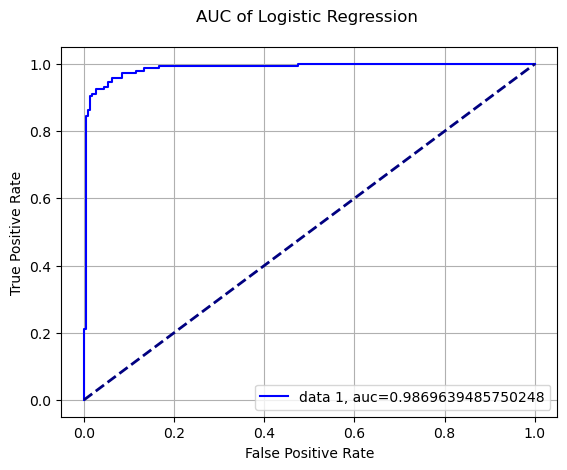

In [102]:
y_pred_proba = lr_best.predict_proba(xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest, y_pred_proba)
lr_auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(lr_auc),color='blue')
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.title("AUC of Logistic Regression \n")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.grid(True)
plt.show()

### Support Vector Machine (SVM)

In [103]:
from sklearn.svm import SVC

In [104]:
clf = SVC(probability=True)
param_grid = {'C': [0.1, 1, 10, 100, 1000], 
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']} 
 
clf_grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3)
clf_grid.fit(xtrain, ytrain)
print(clf_grid.best_params_) #To display the best parameter

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.656 total time=   0.4s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.645 total time=   0.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.666 total time=   0.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.649 total time=   0.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.644 total time=   0.4s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.656 total time=   0.4s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.645 total time=   0.4s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.666 total time=   0.4s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.649 total time=   0.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.644 total time=   0.4s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.599 total time=   0.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.936 total time=   0.4s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.940 total time=   0.4s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.950 total time=   0.4s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.953 total time=   0.4s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.953 total time=   0.4s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.953 total time=   0.4s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.940 total time=   0.4s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.960 total time=   0.4s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.963 total time=   0.4s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.946 total time=   0.4s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.943 total time=   0.4s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.933 total time=   0.3s
[CV 4/5] END ....C=1000, gam

In [105]:
clf_best = SVC(C = 10, gamma = 0.1, kernel = 'rbf') #Sub the best parameter when instantiate model
clf_best.fit(xtrain,ytrain)
clf_pred =  clf_best.predict(xtest)
clf_acc = (clf_best.score(xtest,ytest)) * 100
print('Support Vector Machine (SVM) accuracy : {:.2f}%'.format(clf_acc))

Support Vector Machine (SVM) accuracy : 93.85%


In [106]:
print(classification_report(ytest,clf_pred))
clf_pre = precision_score(ytest, clf_pred) * 100
clf_rec = recall_score(ytest, clf_pred)* 100
clf_f1 = f1_score(ytest, clf_pred)* 100

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       227
           1       0.98      0.86      0.92       147

    accuracy                           0.94       374
   macro avg       0.95      0.93      0.93       374
weighted avg       0.94      0.94      0.94       374



In [107]:
clf_cm = confusion_matrix(ytest,clf_pred)
plt.subplots(figsize=(5,5))
sb.heatmap(clf_cm,annot=True,fmt="d",linewidths=0.5)
plt.title("Support Vector Machine (SVM) Confusion Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

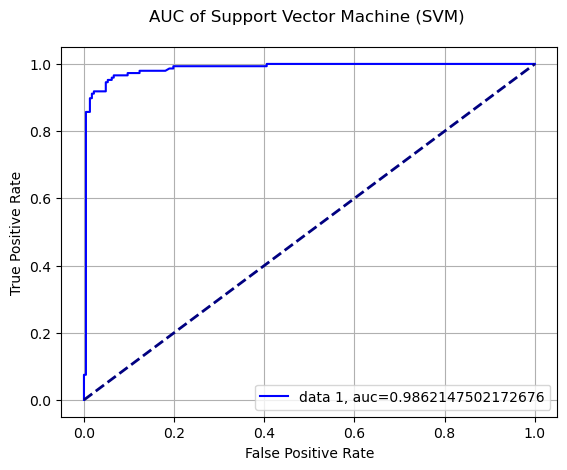

In [108]:
y_pred_proba = clf_grid.predict_proba(xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest, y_pred_proba)
clf_auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(clf_auc),color='blue')
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.title("AUC of Support Vector Machine (SVM) \n")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.grid(True)
plt.show()

### Multinomial Naive Bayes

In [109]:
from sklearn.naive_bayes import MultinomialNB

In [110]:
mnb = MultinomialNB()
params_NB = {
'alpha': (1, 0.1, 0.01, 0.001, 0.0001, 0.00001)  
}
mnb_grid = GridSearchCV(mnb,params_NB)
mnb_grid.fit(xtrain, ytrain)
print(mnb_grid.best_params_)

{'alpha': 1}


In [111]:
mnb_best = MultinomialNB(alpha = 1)
mnb_best.fit(xtrain,ytrain)
mnb_pred =  mnb_best.predict(xtest)
mnb_acc = (mnb_best.score(xtest,ytest)) * 100
print('Multinomial Naive Bayes accuracy : {:.2f}%'.format(mnb_acc))

Multinomial Naive Bayes accuracy : 94.92%


In [112]:
print(classification_report(ytest,mnb_pred))
mnb_pre = precision_score(ytest, mnb_pred) * 100
mnb_rec = recall_score(ytest, mnb_pred)* 100
mnb_f1 = f1_score(ytest, mnb_pred)* 100

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       227
           1       0.97      0.90      0.93       147

    accuracy                           0.95       374
   macro avg       0.95      0.94      0.95       374
weighted avg       0.95      0.95      0.95       374



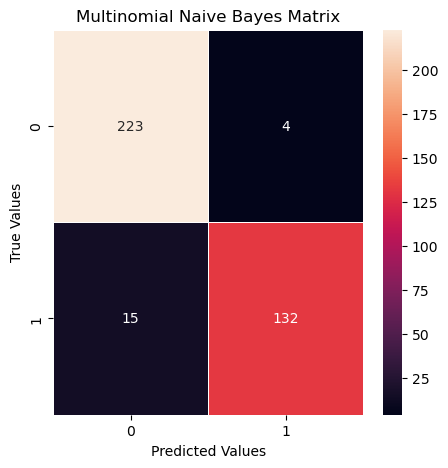

In [113]:
mnb_cm = confusion_matrix(ytest,mnb_pred)
plt.subplots(figsize=(5,5))
sb.heatmap(mnb_cm,annot=True,fmt="d",linewidths=0.5)
plt.title("Multinomial Naive Bayes Matrix")
plt.xlabel("Predicted Values")
plt.ylabel("True Values")
plt.show()

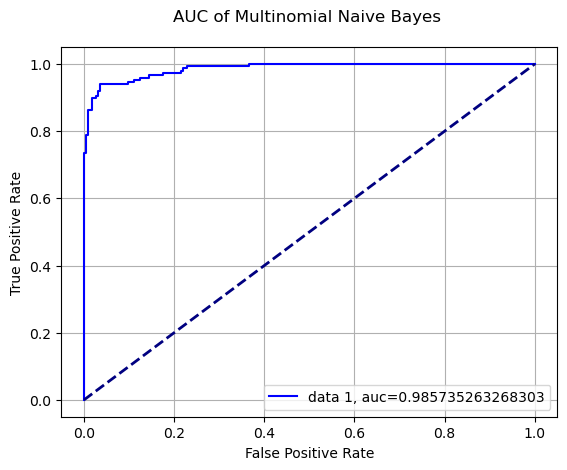

In [114]:
y_pred_proba = mnb_grid.predict_proba(xtest)[::,1]
fpr, tpr, _ = metrics.roc_curve(ytest, y_pred_proba)
mnb_auc = metrics.roc_auc_score(ytest, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(mnb_auc),color='blue')
lw = 2
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.legend(loc=4)
plt.title("AUC of Multinomial Naive Bayes \n")
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.grid(True)
plt.show()

### Comparison

In [122]:
al_name = ['Logistic Regression', 'Support Vector Machine (SVM)', 'Multinomial Naive Bayes']
acc_all = [(al)for al in [lr_acc, clf_acc, mnb_acc]]
pre_all = [(al)for al in [lr_pre, clf_pre, mnb_pre]]
rec_all = [(al)for al in [lr_rec, clf_rec , mnb_rec]]
f1_all = [(al)for al in [lr_f1, clf_f1, mnb_f1]]
auc_all = [(al)for al in [lr_auc * 100, clf_auc * 100, mnb_auc * 100]]

In [123]:
df_model = pd.DataFrame.from_dict({
                    'Model':['Logistic Regression','Support Vector Machine (SVM)','Multinomial Naive Bayes'],
                    'Accuracy':[lr_acc, clf_acc, mnb_acc],
                    'Precision':[lr_pre, clf_pre, mnb_pre],
                    'Recall':[lr_rec, clf_rec, mnb_rec],
                    'F1-Score':[lr_f1, clf_f1, mnb_f1],
                    'AUC':[lr_auc * 100, clf_auc * 100, mnb_auc * 100]
                    }).set_index('Model')

print(display(df_model))

Accuracy  Precision     Recall   F1-Score  \
Model                                                                      
Logistic Regression           94.117647  98.449612  86.394558  92.028986   
Support Vector Machine (SVM)  93.850267  97.692308  86.394558  91.696751   
Multinomial Naive Bayes       94.919786  97.058824  89.795918  93.286219   

                                    AUC  
Model                                    
Logistic Regression           98.696395  
Support Vector Machine (SVM)  98.621475  
Multinomial Naive Bayes       98.573526

None


### Deployment

In [124]:
#To save the best model (Logistic Regression) to a file then next time no need to re-run whole program and run this deployment
#But if the model have changes then need to run again the joblib.dump(lr_best,'bestmodel')
#But if the model no changes then no need to run again the joblib.dump(lr_best,'bestmodel')
joblib.dump(lr_best,'bestmodel')

['bestmodel']

In [125]:
#Get user input
df = pd.read_csv("mail_data.csv")
x = df["Message"]
mail = input("Enter your mail content : ")
mail = [mail]
feature_extraction = TfidfVectorizer(min_df=1,stop_words="english",lowercase=True)
x_feature = feature_extraction.fit_transform(x)
mail_trans = feature_extraction.transform(mail)
lr = joblib.load('bestmodel')
pred = lr.predict(mail_trans)
if(pred[0]==1):
    print("Spam Mail")
elif(pred[0]==0):
    print("Ham Mail")
else:
    print("Some error occurs")

Enter your mail content : aiowhd gyguyid awd
Ham Mail
